# Power analysis

In [399]:
import json
import os
import numpy as np
import re
import pandas as pd

seed = 37
np.random.seed(seed)

In [400]:
# Data INPUT to be written to a JSON file
name_architectures = [
    'Clements_Arct',
    'Fldzhyan_Arct',
    'NEUROPULSCrossingSide_Arct']

arct = 'Clements_Arct'

n_inputs = 4
if n_inputs == 4:
    n_epochs = 20000
elif n_inputs == 6:
    n_epochs = 21000
elif n_inputs == 8:
    n_epochs = 22000
elif n_inputs == 10:
    n_epochs = 23000
elif n_inputs == 12:
    n_epochs = 24000
elif n_inputs == 14:
    n_epochs = 25000
elif n_inputs == 16:
    n_epochs = 26000

directory_run = 'outdata/20240902_run_8_gaus'

name_file = "traking_powers_"+arct+"_N"+str(n_inputs)

data = {
    "name_file": name_file,
    "arct": arct,
    "n_inputs": n_inputs,
    "n_epochs": n_epochs,
    "date": "20240902",
    "train_type": "1-Fidelity",
    "seed": 37,
    "n_matrices": 1000,
    "n_repetitions": 5,
    "lr": 0.001,
    "n_bachup": 500,

    "data_out_type": "insertionlosses",
    "rep_type": "all repetitions take considerations",
    "num_vectors": 1000,
    "simulations": []
    }

folder_relative_path = "organized_data/"

if True:
    # Write JSON data to a file
    with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [401]:
def append_gaussian_output_simulation(data, pc_iloss_mu, pc_iloss_sigma, imbalance_mu, i_loss=None,
                                      i_loss_q25=None, i_loss_q50=None, i_loss_q75=None,
                                      i_loss_q25_dB=None, i_loss_q50_dB=None, i_loss_q75_dB=None,):
    dictionary = {
        "pc_iloss_mu": pc_iloss_mu,
        "pc_iloss_sigma": pc_iloss_sigma,
        "i_loss_MMI_mu": -0.5,
        "i_loss_MMI_sigma": 0.1,
        "imbalance_mu": imbalance_mu,
        "imbalance_sigma": 0.15,
        "i_loss_Crossing_mu": -0.2,
        "i_loss_Crossing_sigma": 0.05,
        "cross_talk_mu": -35.0,
        "cross_talk_sigma": 1.0,

        "i_loss": i_loss,
        "i_loss_q25": i_loss_q25,
        "i_loss_q50": i_loss_q50,
        "i_loss_q75": i_loss_q75,
        "i_loss_q25_dB": i_loss_q25_dB,
        "i_loss_q50_dB": i_loss_q50_dB,
        "i_loss_q75_dB": i_loss_q75_dB
        }
    
    data["simulations"].append(dictionary)

In [402]:
# Read
with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'r') as file:
    data = json.load(file)

# Derive the insertion LOSSES

In [403]:
# Extract data matrix of the predictions matricies
def extract_prediction_matrices_1sim(directory, arct):
    prediction_matrices = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            predic_m = [array for label, array in result_sim if arct in label and "prediction" in label]
        if predic_m:    # If there are elements
            prediction_matrices.extend(predic_m)
    return prediction_matrices

# Create the inputs (electri fiels so I need to make uniform distribute in the complex between -1 and 1)
def define_inputs_eletrical_fields(num_vectors, n_inputs):
    real_part = np.random.uniform(-1, 1, (num_vectors, n_inputs))
    imaginary_part  = np.random.uniform(-1, 1, (num_vectors, n_inputs))
    complex_vector = real_part + 1j * imaginary_part
    return complex_vector

def extract_values(simulation_folder):
    # Patterns to match each value, ensuring correct order
    patterns = {
        'pcilossmu': r"pcilossmu(-?\d+\.\d+)",
        'pcilosssigma': r"pcilosssigma(-?\d+\.\d+)",
        'imbalancemu': r"imbalancemu(-?\d+\.\d+)",
    }
    values = {}
    last_end = 0  # Track the end position of the last match
    for key, pattern in patterns.items():
        match = re.search(pattern, simulation_folder[last_end:])
        if match:
            values[key] = float(match.group(1))
            last_end += match.end()
    return values

# Derive the losses my making the moltiplipication matrix for 
def model_losses(preditions, input_vectors, simulation_folder):
    preditions = np.array(preditions)
    input_vectors = np.array(input_vectors)
    power_in_tots = np.sum(np.abs(input_vectors)**2, axis=1)
    
    losses = []
    for matrix in preditions:
        output_vectors = []
        for input_v in input_vectors:
            output_vectors.append(np.dot(matrix, input_v))
        power_out_tots = np.sum(np.abs(output_vectors)**2, axis=1)
        losses.extend(power_out_tots/power_in_tots)
    losses_dB = 10 * np.log10(losses)
    q25 = np.percentile(losses, 25)
    q50 = np.percentile(losses, 50)
    q75 = np.percentile(losses, 75)
    q25_dB = np.percentile(losses_dB, 25)
    q50_dB = np.percentile(losses_dB, 50)
    q75_dB = np.percentile(losses_dB, 75)
    
    # Extract and convert to float
    extract_hyp = extract_values(simulation_folder)
    losses_pd = pd.DataFrame([{'simulation':simulation_folder,
                               'pcilossmu': extract_hyp['pcilossmu'],
                               'pcilosssigma': extract_hyp['pcilosssigma'],
                               'imbalancemu': extract_hyp['imbalancemu'],
                               'i_loss_q25': q25,
                               'i_loss_q50': q50,
                               'i_loss_q75': q75,
                               'i_loss_q25_dB': q25_dB,
                               'i_loss_q50_dB': q50_dB,
                               'i_loss_q75_dB': q75_dB}])

    return losses_pd


# =================================================================================================================
# MAIN
# =================================================================================================================
data_df = pd.DataFrame()
input_vectors = define_inputs_eletrical_fields(data["num_vectors"], data["n_inputs"])
for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if "n"+str(data["n_inputs"]) in directory_path:             # I don't like it but ok
        if not os.path.isfile(directory_path):
            pred_matrix = extract_prediction_matrices_1sim(directory_path, data["arct"])
            print("Number of data saved:", len(pred_matrix))
            if pred_matrix != []:   # No data in that simulation
                simulation_folder = os.path.basename(directory_path)
                losses_pd = model_losses(pred_matrix, input_vectors, simulation_folder)
                data_df = pd.concat([data_df, losses_pd], ignore_index=True)

Number of data saved: 5000


## Write inside the JSON file

In [404]:
# Read
with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'r') as file:
    data = json.load(file)

for index, row in data_df.iterrows():
    # !!!!!!!!!!!! I'm APPENDING ELEMENTS !!!!!!!!!!!!!!!!!!!!!!!!!!!
    append_gaussian_output_simulation(
        data=data,
        pc_iloss_mu=row['pcilossmu'],
        pc_iloss_sigma=row['pcilosssigma'],
        imbalance_mu=row['imbalancemu'],
        i_loss_q25=row['i_loss_q25'],
        i_loss_q50=row['i_loss_q50'],
        i_loss_q75=row['i_loss_q75'],
        i_loss_q25_dB=row['i_loss_q25_dB'],
        i_loss_q50_dB=row['i_loss_q50_dB'],
        i_loss_q75_dB=row['i_loss_q75_dB'],)

if True:
    # Write JSON data to a file
    with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

## Sort by imb

In [405]:
# Sort the dictionary by PC_i_loss and imbalances
import json

# Read
with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'r') as file:
    data = json.load(file) 


# Sort by PhaseChanger IMBALANCE MU
simulations = data["simulations"]
sorted_simulations = sorted(simulations, key=lambda x: x['imbalance_mu'])
data["simulations"] = sorted_simulations

# Sort by PhaseChanger INSERTION LOSS MU
simulations = data["simulations"]
sorted_simulations = sorted(simulations, key=lambda x: x['pc_iloss_mu'])
data["simulations"] = sorted_simulations

# Sort by PhaseChanger INSERTION LOSS SIGMA
simulations = data["simulations"]
sorted_simulations = sorted(simulations, key=lambda x: x['pc_iloss_sigma'])
data["simulations"] = sorted_simulations

if True:
    # Write JSON data to a file
    with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

Vector 1: [0.34360162 0.24085737 0.15523975 0.26969772 0.27840712 0.29245171
 0.11370881 0.30526132], Sum: 1.9992254177029625
Vector 2: [0.18774287 0.30688446 0.31478279 0.28004477 0.23544873 0.34703482
 0.33486314 0.15684558], Sum: 2.163647160492803
Vector 3: [0.27293569 0.26771649 0.29684789 0.34081924 0.0800233  0.12981332
 0.1209486  0.21351954], Sum: 1.7226240688122774
Vector 4: [0.31690118 0.34825327 0.2040157  0.24454546 0.14955661 0.33588214
 0.30894492 0.15766282], Sum: 2.065762106576079
Vector 5: [0.21380077 0.27285121 0.07079395 0.3210584  0.28290267 0.04890937
 0.31741896 0.22497018], Sum: 1.7527055215688665


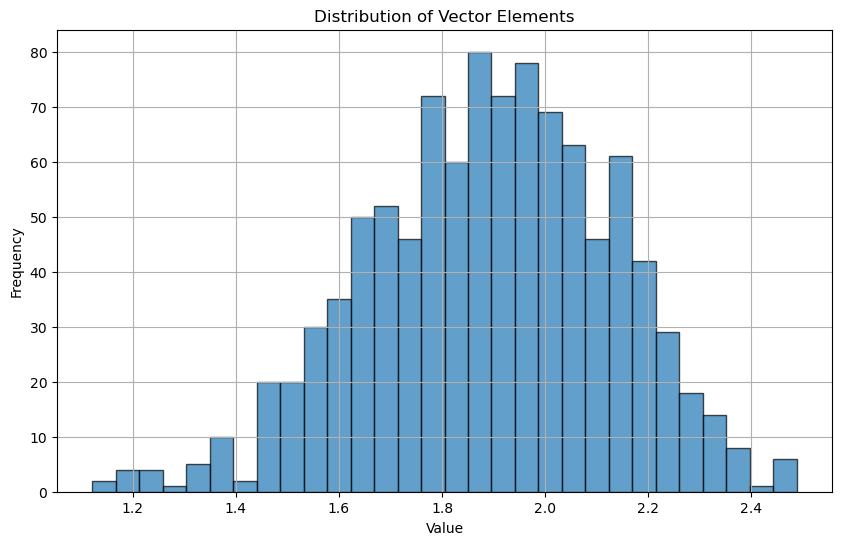

In [406]:
# Create 1000 random inputs uniform distribution
import matplotlib.pyplot as plt
np.random.seed(seed)

def generate_inputs(num_inputs, n, seed):
    np.random.seed(seed)
    vectors = np.sqrt(np.random.uniform(0, 1, (num_inputs, n))/n)
    return vectors

# Parameters
num_inputs = 1000
n = 8  # Example length, you can change this

# Generate vectors
inputs = generate_inputs(num_inputs, n, seed)

for i, vector in enumerate(inputs[:5]):
    print(f"Vector {i + 1}: {vector}, Sum: {np.sum(vector)}")


# Flatten the array to get a single array of all elements
all_elements = np.sum(inputs, axis=1).flatten()

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(all_elements, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Vector Elements')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

